# Setup some variables

In [18]:
from pathlib import Path

DATA_DIR = "./data"
APPLE_IMAGE_PATH = str(Path(DATA_DIR, "apple.png"))
SEA_IMAGE_PATH = str(Path(DATA_DIR, "sea_with_coral.png"))
MASK_IMAGE_OUTPUT_PATH = str(Path(DATA_DIR, "mask.png"))
BLENDED_IMAGE_OUTPUT_PATH = str(Path(DATA_DIR, "output.png"))

print(APPLE_IMAGE_PATH)
print(SEA_IMAGE_PATH)
print(BLENDED_IMAGE_OUTPUT_PATH)
print(MASK_IMAGE_OUTPUT_PATH)

data/apple.png
data/sea_with_coral.png
data/output.png
data/mask.png


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def convert_bgr2rgb(image_bgr):
    return cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)


def pil2cv(image_pil, convert_channel=True):
    image_np = np.array(image_pil, dtype=np.uint8)
    if convert_channel:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    return image_np


def show_image_from_ndarray(image_array, bgr2rgb=True):
    if (len(image_array.shape) < 3) or (image_array.shape[-1] == 1):
        plt.imshow(image_array)
        plt.axis("off")
    else:
        if bgr2rgb:
            plt.imshow(convert_bgr2rgb(image_array))
        else:
            plt.imshow(image_array)
        plt.axis("off")


def segmentation_by_hsv(image_bgr, hsv_lower, hsv_upper):
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    return cv2.inRange(hsv, np.array(hsv_lower), np.array(hsv_upper))


def get_largest_contour_mask(mask_filled_depth):
    mask_largest_contour = np.zeros_like(mask_filled_depth)
    contours, _ = cv2.findContours(mask_filled_depth, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        raise SystemError("[get_largest_contour_mask] len(contours) != 0")
    largest_contour = max(contours, key=cv2.contourArea)
    cv2.drawContours(mask_largest_contour, [largest_contour], -1, 255, -1)
    return mask_largest_contour


# Load some images

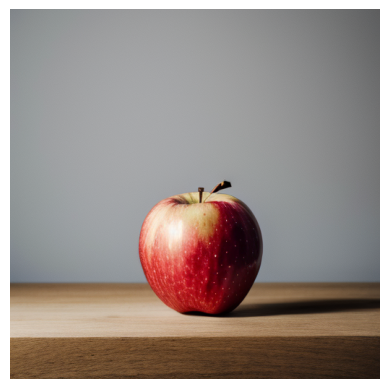

In [20]:
import cv2

image_fg = cv2.imread(APPLE_IMAGE_PATH)
show_image_from_ndarray(image_fg)

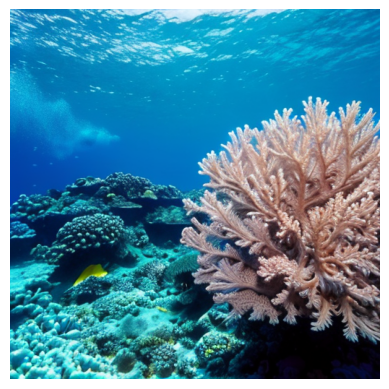

In [21]:
image_bg = cv2.imread(SEA_IMAGE_PATH)
show_image_from_ndarray(image_bg)

# Extract Red Area

In [22]:
def extract_red_area(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 赤色の領域を抽出する
    mask1 = cv2.inRange(image_hsv, (0, 50, 50), (10, 255, 255))
    mask2 = cv2.inRange(image_hsv, (170, 50, 50), (180, 255, 255))

    # マスクを合成
    mask = get_largest_contour_mask(cv2.bitwise_or(mask1, mask2))

    # 凸包を計算する
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull = cv2.convexHull(contours[0])

    # 凸包の内側にあるマスクを作成する
    hull_mask = np.zeros_like(mask)
    cv2.drawContours(hull_mask, [hull], 0, 255, -1)

    return hull_mask

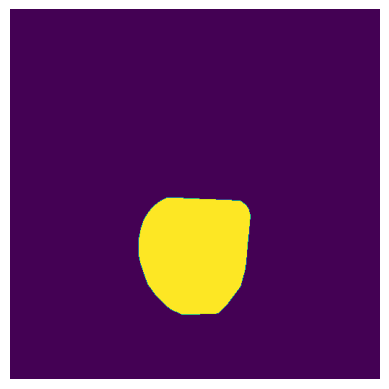

In [23]:
mask_red_area = extract_red_area(image_fg)
show_image_from_ndarray(mask_red_area)

In [24]:
def get_circular_mask(mask):
    # 内部の輪郭を取得する
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 内側の輪郭の重心と面積を計算する
    cnt = contours[0]
    M = cv2.moments(cnt)
    center = (int(M['m10']/M['m00']), int(M['m01']/M['m00']))
    area = cv2.contourArea(cnt)

    # 内側の輪郭を円近似する
    (x,y), radius = cv2.minEnclosingCircle(cnt)
    center = (int(x), int(y))
    radius = int(radius)

    mask_circular = np.zeros_like(mask)
    return cv2.circle(mask_circular, center, radius, 255, -1)

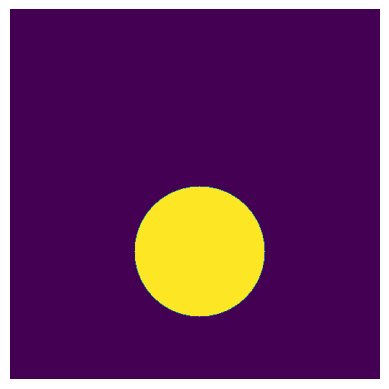

In [25]:
circular_mask = get_circular_mask(mask_red_area)
show_image_from_ndarray(circular_mask)

-1

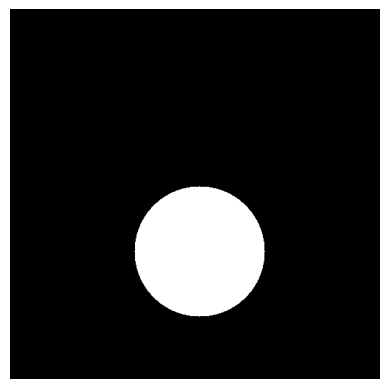

In [26]:
circular_mask_ch3 = cv2.cvtColor(circular_mask, cv2.COLOR_GRAY2BGR)
show_image_from_ndarray(circular_mask_ch3)

cv2.imwrite(MASK_IMAGE_OUTPUT_PATH, circular_mask_ch3)
cv2.waitKey(10)

# Blending

In [27]:
import cv2
import numpy as np
from pyamg.gallery import poisson
from pyamg import ruge_stuben_solver, solve


def poisson_blend(src, dst, mask, blend_alpha=0.5):
    # 1. マスクされたソース画像とマスク領域の輪郭を求める
    src_masked = src.copy()
    src_masked[mask == 0] = 0
    contours, _ = cv2.findContours(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 2. ソース画像と同じサイズで、最初は全ての値が0の出力画像を用意する
    # output = np.zeros_like(src)
    output = dst.copy()

    # 3. 各チャンネルに対して、ポアソン方程式を解いて、ソース画像を出力画像にブレンドする
    for i in range(3):
        # ソース画像、出力画像、マスクされたソース画像、ソース画像のラプラシアンを用意する
        src_channel = src[:, :, i]
        output_channel = output[:, :, i]
        src_masked_channel = src_masked[:, :, i]
        laplacian = poisson((src.shape[0], src.shape[1]), format="csr") * src_channel.flatten()
        laplacian = laplacian.reshape(src_channel.shape)

        # マスク領域の外側には出力画像をコピーし、内側にはポアソン方程式で求めたブレンド画像をコピーする
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 0 and h > 0:
                dst_roi = dst[y : y + h, x : x + w, i]
                src_roi = src_masked_channel[y : y + h, x : x + w]
                output_roi = output_channel[y : y + h, x : x + w]
                mask_roi = mask[y : y + h, x : x + w, i]

                # ポアソン方程式の係数行列と定数ベクトルを作成する
                A = poisson((h, w), format="csr")
                b = np.zeros_like(src_roi)

                b[1:-1, 1:-1] = (
                    laplacian[y + 1 : y + h - 1, x + 1 : x + w - 1]
                    + src_roi[1:-1, 1:-1]
                    - src_roi[1:-1, :-2]
                    - src_roi[1:-1, 2:]
                    - src_roi[:-2, 1:-1]
                    - src_roi[2:, 1:-1]
                )

                # ブレンド画像を求める
                solver = ruge_stuben_solver(A)
                blended = solver.solve(b.flatten()).reshape((h, w))
                blended = np.clip(blended, 0.0, 1.0)
                output[y : y + h, x : x + w, i] = dst_roi
                diff = blended - src_roi
                diff[mask_roi == 0] = 0

                src_roi_filled = src_roi.copy()
                src_roi_filled[mask_roi == 0] = dst_roi[mask_roi == 0]
                output[y : y + h, x : x + w, i] = (output[y : y + h, x : x + w, i] - diff) * blend_alpha + (1 - blend_alpha) * src_roi_filled
    return output


Elapsed time: 0.7325398921966553 [sec]


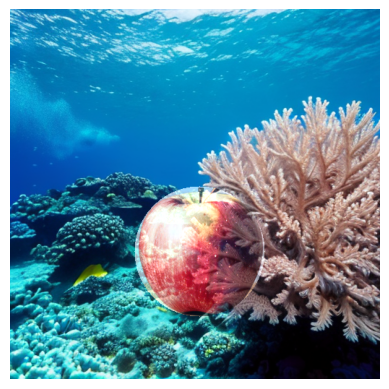

In [28]:
import time

image_fg_f = image_fg.astype(np.float32) / 255
image_bg_f = image_bg.astype(np.float32) / 255

start = time.time()
result_cpu = poisson_blend(image_fg_f, image_bg_f, circular_mask_ch3, blend_alpha=0.5)
end = time.time()
print(f"Elapsed time: {end - start} [sec]")

result = (np.clip(result_cpu, 0.0, 1.0) * 255).astype(np.uint8)
cv2.imwrite(BLENDED_IMAGE_OUTPUT_PATH, result)
cv2.waitKey(10)

show_image_from_ndarray(result)